# 딥러닝 (Week 13. Reinforcement Learning)

by Kyoungwon Seo (Dept. of Applied Artificial Intelligence, SeoulTech)
- e: kwseo@seoultech.ac.kr
- w: https://hai.seoultech.ac.kr

강의계획
1. 보상을 최적화하기 위한 학습
2. 정책 탐색
3. OpenAI 짐
  - 설정
  - 간단한 하드 코딩 정책
4. 신경망 정책
5. 행동 평가: 신용 할당 문제
6. 정책 그레디언트
7. 마르코프 결정 과정

## 0. 역사

- 1) 강화학습(reinforcement learning; RL)의 성과
  - (1) 2013년 영국 스타트업 딥마인드 연구팀의 게임 <아타리> 플레이
    - https://youtu.be/V1eYniJ0Rnk
    - https://arxiv.org/abs/1312.5602
    - https://www.nature.com/articles/nature14236?wm=book_wap_0005
  - (2) 2016년, 2017년 알파고의 바둑 대국

- 2) 강화학습 핵심 기술
  - (1) 정책 그레디언트 (policy gradient)
  - (2) 마르코프 결정 과정 (MDP; Markov decision process)

## 1. 강화학습

### 1) 개념

- (0) 요약 : 보상을 최적화하기 위한 학습
- (1) 요소 : 강화학습에서 소프트웨어 에이전트(agent)는 관측(observation)하고 주어진 환경(environment)에서 행동(action)을 함
- (2) 결과 : 행동의 결과로 보상(reward)을 받음
- (3) 목적 : 에이전트의 목적은 보상의 장기간 기대치를 최대로 만드는 행동을 학습하는 것

### 2) 예시

- 예: 게임 <아타리>
  - 에이전트: 제어하는 프로그램
  - 환경: 게임 시뮬레이션
  - 행동: 가능한 움직임
  - 관측: 스크린샷
  - 보상: 게임의 점수

### 3) 활용

- 강화학습 적용 사례: 
  - 자율주행 자동차 (https://youtu.be/VMp6pq6_QjI)
  - 로봇 (https://youtu.be/W1EMChcjkKA)

### 4) 정책 탐색

#### (1) 정책

1] 개념

- 정책 (policy)
  - 소프트웨어 에이전트가 행동을 결정하기 위해 사용하는 알고리즘
  - 예: 관측을 입력으로 받고 수행할 행동을 출력하는 신경망 (아래 그림) ♣

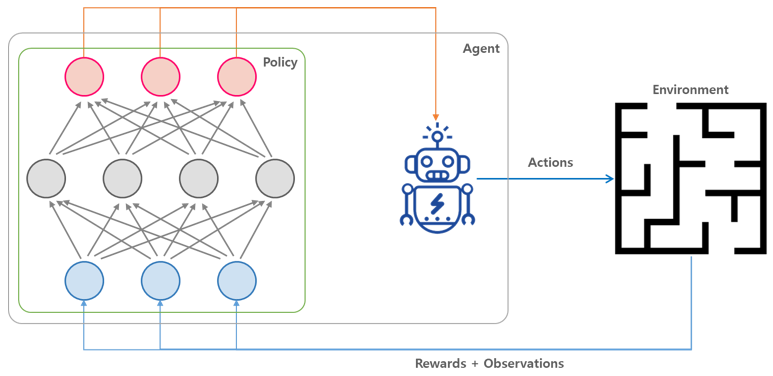

2] 종류

- [1] 확률적 정책 (stochastic policy)
  - 무작위성이 포함된 정책
  - 예: 청소로봇이 매 초마다 어떤 확률 p만큼 전진하고, (1-p)의 확률로 랜덤하게 회전
  - 보상과 관측은 "얼마나 많은 먼지를 수집할 것인가"

3] 정책 요소

- [1] 정책 파라미터 (policy parameter)
  - 위 청소로봇의 예제 속 정책 파라미터는 확률 p와 회전의 각도 r

- [2] 정책 공간 (policy space) ♣
  - 정책 탐색을 할 수 있는 정책 파라미터의 조합
  - 정책 공간이 매우 크면 좋은 파라미터 조합을 찾는데 매우 많은 시간이 소요됨

#### (2) 정책 탐색

1] 개념

- 정책 탐색 (policy search)
  - 다양한 정책 파라미터를 시도해보고, 가장 성능이 좋은 조합을 고르는 학습 알고리즘

2] 종류

- 정책 공간 탐색방법
  - [1] 유전 알고리즘 (genetic algorithm)
    - 1세대 정책 100개를 랜덤하게 생성해서 시도한 후, 성능이 낮은 정책 80개는 버리고 20개를 살려 각각 자식 정책 4개를 생산 (자식 정책은 부모 정책을 일부 복사한 후 약간의 무작위성을 더함)
    - 이런 식으로 여러 세대에 걸쳐서 반복 -> overfitting 방지 가능 ♣
  - [2] 정책 그레디언트 (PG; policy gradient)
    - 정책 파라미터에 대한 보상의 그레디언트를 평가해 높은 보상의 방향을 따르는 그레디언트로 파라미터를 수정하는 최적화 기법
    - 청소로봇 예제에서 p를 조금 증가시켰을 때 수집한 먼지 양이 많아졌다면 p를 조금 증가시키고 그렇지 않다면 p를 감소

## 3. OpenAI Gym 예제

- 환경 설정

In [6]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 코랩에서 실행하고 있나요?
IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym>=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 부드러운 애니메이션을 위해
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 https://develo

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-agents 0.14.0 requires gym<=0.23.0,>=0.17.0, but you have gym 0.26.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 2.1 MB 41.6 MB/s 
     |████████████████████████████████| 1.7 MB 48.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441028 sha256=9b8ca19f0254ead152c2eea6f9baca9ebae20dffe2e3d76a7fb72c166761bed3
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-

- 강화학습에서는 에이전트 훈련을 위한 작업환경 마련이 필요
  - 게임 : 게임 시뮬레이터
  - 로봇 : 실제 세상이 가능하지만 제약조건이 있음 ♣
    - 로봇이 절벽에서 떨어진다면? 훈련 속도는?
  - 훈련을 위한 시뮬레이션 환경이 필요 --> OpenAI 짐 (https://www.gymlibrary.dev/)

먼저 `gym`을 임포트

In [1]:
import gym

가능한 환경 목록을 확인

In [2]:
gym.envs.registry.all()

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:422: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  "The `registry.all` method is deprecated. Please use `registry.values` instead."


dict_values([EnvSpec(id='CartPole-v0', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=0), EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=1), EnvSpec(id='MountainCar-v0', entry_point='gym.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='MountainCar', version=0), EnvSpec(id='MountainCarContinuous-v0', entry_point='gym.envs.classic_control.co

Cart-Pole 환경 사용
- 매우 간단한 환경으로 왼쪽과 오른쪽으로 움직이는 카트와 그 위에 수직으로 놓여 있는 막대로 구성
- 에이전트는 카트를 왼쪽이나 오른쪽으로 움직여 막대가 바로 서 있도록 만들어야 함

In [3]:
env = gym.make('CartPole-v1')

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


- `reset()` 메서드를 호출해 환경을 초기화
- 이 메서드는 관측을 반환함

In [4]:
env.seed(42)
obs = env.reset()

/usr/local/lib/python3.7/dist-packages/gym/core.py:257: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


4개의 실수로 구성된 1D 넘파이 배열 관측 ♣
- 카트의 수평 위치
- 속도
- 막대의 각도(0=수직)
- 각속도

In [5]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

환경은 `render()` 메서드를 호출하여 시각화

In [7]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [8]:
env.render()

/usr/local/lib/python3.7/dist-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


`mode="rgb_array"`로 지정해 환경 이미지를 넘파이 배열로 받음

In [9]:
img = env.render(mode="rgb_array")
img.shape

/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


(400, 600, 3)

In [10]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

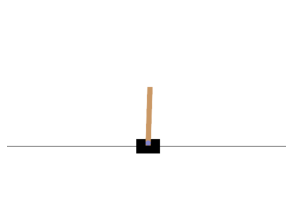

In [11]:
plot_environment(env)
plt.show()

환경과 상호작용
- 에이전트는 "행동 공간"(가능한 행동의 집합)에서 하나의 행동을 선택
- 이 환경의 행동 공간을 아래와 같이 확인

In [12]:
env.action_space

Discrete(2)

두 개의 행동이 가능
- 완쪽으로 가속
- 오른쪽으로 가속

막대가 오른쪽으로 기울어져 있기 때문에(`obs[2] > 0`), 카트를 오른쪽으로 가속

In [13]:
action = 1  # 오른쪽으로 가속
obs, reward, done, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

관측 결과
- 카트가 오른쪽으로 움직임(`obs[1] > 0`)
- 막대가 여전히 오른쪽으로 기울어져 있음(`obs[2] > 0`)
- 하지만 각속도가 음수이므로(`obs[3] < 0`) 다음 스텝에서는 왼쪽으로 기울 것 같음

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

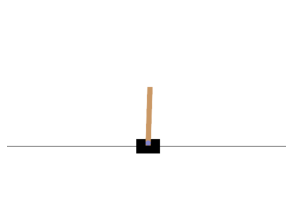

In [14]:
plot_environment(env)

이전 스텝에서의 보상 확인

In [15]:
reward

1.0

게임이 끝나면 환경은 `done=True`를 반환

In [16]:
done

False

`info`
- 훈련이나 디버깅에 유용한 추가적인 정보를 담은 환경에 특화된 딕셔너리
- 예: 일부 게임에서는 얼마나 많은 에이전트의 생명이 몇 개가 남아 있는지 나타낼 수 있음

In [17]:
info

{}

에피소드
- 환경이 재설정된 순간부터 종료될 때까지 스텝 시퀀스
- 에피소드 끝에서 (즉, `step()`이 `done=True`를 반환할 때), 계속하기 전에 환경을 재설정해야 함

In [18]:
if done:
    obs = env.reset()

- 막대를 똑바로 유지하기 위해서는? ♣
  - 정책을 정의해야 함
  - 에이전트가 매 스텝마다 행동을 선택하기 위해 사용할 전략
  - 어떤 행동을 선택할지 결정하기 위해 지난 행동과 관측을 모두 사용할 수 있음

- 간단한 하드 코딩 정책
  - 막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 움직임
  - 막대가 오른쪽으로 기울어지면 카트를 오른쪽으로 움직임

In [19]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

/usr/local/lib/python3.7/dist-packages/gym/core.py:257: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


In [20]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.212, 9.032998173364147, 24.0, 72.0)

- 결과
  - 너무 단순해 최대로 막대를 유지한 스텝 횟수가 68
  - 이 환경은 에이전트가 막대를 200 스텝 이상 유지해야 해결된 것으로 간주함

- 하나의 에피소드를 시각화:

In [21]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

- 애니메이션을 출력:

In [22]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [23]:
plot_animation(frames)

### 2) 정책 탐색 이어서

#### (4) 정책 탐색 이어서

3] 종류

[3] 신경망 정책

- 관측을 입력으로 받고 실행할 행동을 출력하는 신경망 (각 행동에 대한 확률을 추정)
- 가장 높은 점수의 행동을 그냥 선택하지 않고 확률을 기반으로 행동을 무작위 선택
  - 에이전트가 새로운 행동을 탐험(exploring)하는 것과 잘할 수 있는 행동을 활용(exploiting)하는 것 사이에 균형 유지

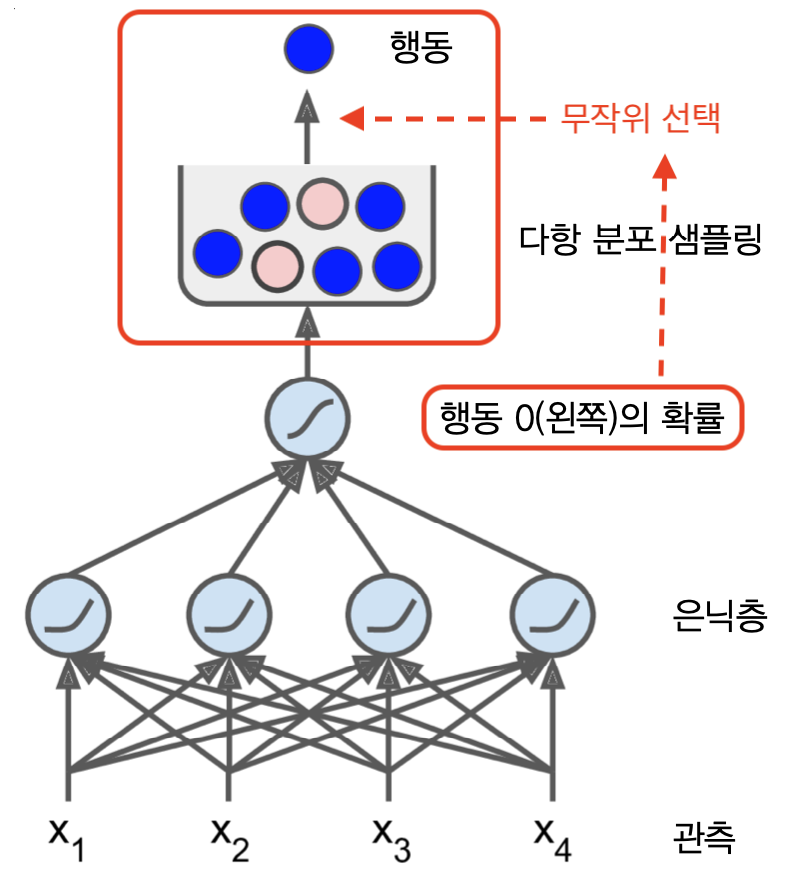

- 관측을 입력으로 받고 각 관측에 대해 선택할 행동의 확률을 출력하는 신경망
  - 하나의 출력 뉴런이 행동 0(왼쪽)의 확률 `p`를 출력
  - 행동 1(오른쪽)의 확률은 `1 - p`가 됨

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

모델을 실행하여 한 에피소드를 플레이하고 애니메이션을 위한 프레임을 반환하는 함수:

In [25]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

랜덤하게 초기화된 정책 네트워크의 성능:

In [26]:
frames = render_policy_net(model)
plot_animation(frames)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

1/1 [==============================] - 0s 21ms/step


- 앞에서 사용한 기본적인 정책을 활용해 학습 진행
  - 막대가 왼쪽으로 기울면 왼쪽으로 움직이고, 오른쪽으로 기울면 오른쪽으로 움직이도록 함
  - 같은 신경망으로 동시에 50개의 다른 환경을 플레이 ♣ 실제 환경에서는 로봇이 50개가 필요한데 시뮬레이션 코딩으로 수행하기 때문에 가능
  - 5000번 반복 동안 훈련
  - 게임이 종료되면 환경을 재설정

In [27]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

Iteration: 4999, Loss: 0.052

In [28]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


1/1 [==============================] - 0s 25ms/step


#### (5) 문제점 : 신용 할당 문제

- 각 스텝에서 가장 좋은 행동이 무엇인지 알고 있다면 추정된 확률과 타깃 확률 사이의 크로스 엔트로피를 최소화하도록 신경망을 훈련할 수 있음 (일반적 지도학습)
- 그러나, 강화학습에서 에이전트가 얻을 수 있는 가이드는 "보상"뿐이고, 이는 일반적으로 지연되어 나타남
  - 예: 100번의 행동 중 어떤 것이 좋고, 어떤 것이 나쁜지 알기 힘듦

- 신용 할당 문제 (credit assignment problem) ♣
  - 즉, 에이전트가 보상을 받았을 때 어떤 행동 덕분인지 (혹은 탓인지) 알기 어려움

#### (6) 해결방안

- 1] 할인 계수 (discount factor) gamma
    - [1] 개념
        - 행동이 일어난 후 각 단계마다 할인 계수를 적용한 보상을 모두 합하여 행동을 평가
        - 대가 (return): 할인된 보상의 합을 행동의 대가라고 부름 ♣ [reward : 보상 그 자체]와 헷갈리면 안된다
    - [2] 특징 ♣
        - 할인 계수가 0에 가까울 수록 현재의 보상이 중요
        - 할인 계수가 1에 가까울 수록 먼 미래의 보상도 중요하게 고려
        - 전형적 할인 계수의 값은 0.9에서 0.99 사이

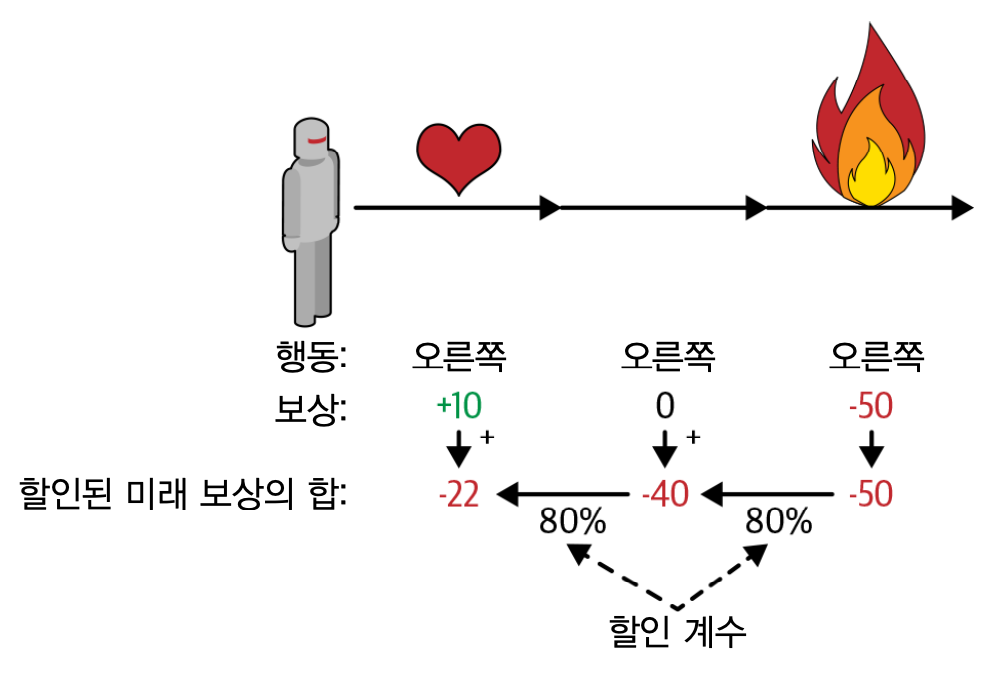

- [3] 예제
  - 위 그림에서 에이전트가 오른쪽으로 세 번 움직이는 행동을 취함
  - 첫째 스텝에서 10, 둘째 스텝에서 0, 셋째 스텝에서 -50의 보상을 받음
  - 따라서 첫째 행동의 대가는 다음과 같이 계산됨: 10+𝛾⋅0+𝛾2⋅(−50)=−22

- 2] 행동이익(action advantage) ♣
    - [1] 개념
        - 대가 정규화: 대가들의 평균과 표준편차를 계산한 후 표준점수로 변환하기: 𝑍=𝑋−𝜇(𝑋)/𝜎(𝑋)
        - 게임을 충분히 많이 실행한 후 계산한 각 행동에 대한 대가를 정규화한 값
        - 많은 에피소드(시물레이션)를 실행하면서 얻은 각 행동에 대한 대가들의 평균값과 표준편차를 계산함
    - [2] 특징
        - 양의 행동이익: 좋은 행동
        - 음의 행동이익: 나쁜 행동

#### (2) 정책 탐색 이어서 

2] 종류 이어서

[2] 정책 그레디언트 이어서

1]] 개념

- 정책 그레디언트 (PG)
  - 높은 보상을 얻도록 신경망 정책 모델의 파라미터를 경사하강법으로 학습시키는 기법
  - REINFORCE 알고리즘: 대표적인 PG 알고리즘 ♣

2]] 순서 ♣

- 작동방식
  1. 신경망 정책 모델을 활용한 게임을 여러 번의 에피소드로 실행하면서 아래 데이터 저장
    - 시뮬레이션의 매 스텝마다 파라미터별로 "그레디언트" 계산해서 저장 ♣
    - 시뮬레이션의 매 스텝마다 "보상"을 확인해서 저장
  2. 모든 에피소드 완료 후 매 스텝의 행동이익 계산
  3. 매 스텝에 대해 행동이익을 저장된 파라미터 그레이디언트와 곱하기
  4. 계산된 모든 그레이디언트의 평균값을 파라미터별로 계산 ♣
  5. 계산된 파라미터별 그레이디언트의 평균값을 신경망 정책 모델에 경사하강법을 이용하여 적용

3]] 구현

- 구현: 스텝 실행 결과 반환 함수 ♣
  - 스텝을 한 번 실행할 때마다 관측과 그레디언트 반환하기 함수
  - 타깃확률(y_target): 0 또는 1
    - 정책 모델이 추천하는 방향을 타깃확률로 지정
    - 따라서 손실(loss)이 최소, 즉, 정책 모델이 가능한 좋은 확률로 행동을 추천하는 방향으로 유도함
  - 그레디언트(grads): 실행된 스텝에서 각 파라미터에 대한 손실함수의 그레디언트

In [29]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

- 구현: 여러 에피소드 실행 결과 반환 함수
  - 에피소드 실행중에 발생하는 매 스텝의 결과인 보상과 그레이디언트를 리스트로 저장
  - 모든 에피소드에 대해 반복

In [30]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

- 구현: 행동이익 반환 함수
  - discount_rewards() 함수
    - 하나의 에피소드 내에서 발생하는 스텝별 보상에 대한 행동대가(return) 계산
  - discount_and_normalize_rewards() 함수
    - 모든 에피소드에 대해 스텝별 행동이익 계산

In [31]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

- 훈련

In [32]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [33]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [34]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [35]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

Iteration: 149, mean rewards: 186.2

In [36]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


1/1 [==============================] - 0s 19ms/step


4]] 문제점 ♣

- 위 정책 그레디언트 알고리즘은 더 크고 복잡한 문제에는 잘 적용되지 못함
  - 샘플 효율성(sample efficiency)이 나쁨: 아주 긴 시간 동안 게임을 플레이해야 정책을 많이 개선할 수 있음
  - 대안:
    - 액터-크리틱(actor-critic) 알고리즘
    - 심층 Q-네트워크 (DQN; deep Q-networks)

[3] 마르코프 결정 과정

1] 마르코프 연쇄 (Markov chain) ♣

- 마르코프 연쇄(Markov chain)
  - 정해진 개수의 상태 s
  - 각 스텝마다 한 상태에서 다른 상태로 랜덤하게 전이
  - 4개의 상태가 있는 마르코프 연쇄:
    - 종료 상태(terminal state): s3

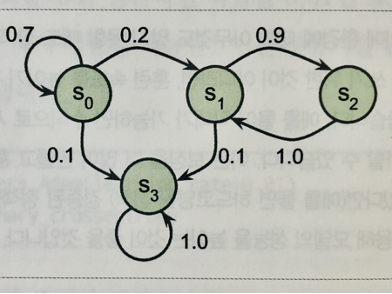

2] 마르코프 결정 과정 (MDP; Markov decision process) ♣

- 마르코프 결정 과정 (MDP; Markov decision process)
  - 마르코프 결정 과정은 마르코프 연쇄와 비슷하지만 차이점 존재 
  - 각 스텝에서 에이전트는 행동 하나는 선택 가능 
  - 전이 확률은 선택된 행동에 따라 달라짐 ♣
  - 어떤 상태 전이는 보상을 반환 
  - 에이전트의 목적은 시간이 지남에 따라 보상을 최대화하기 위한 정책을 찾는 것

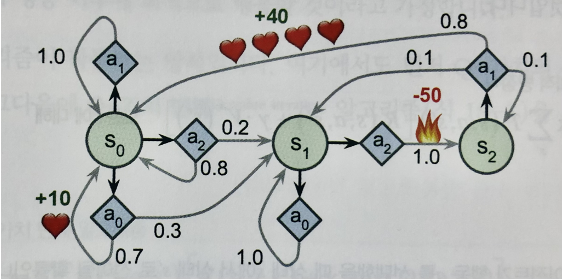

3] 최적 상태 가치 추정 ♣

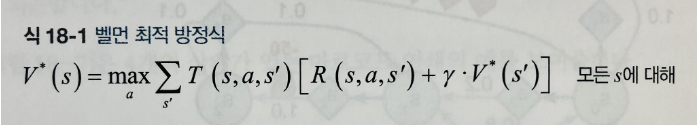

- 최적의 상태 가치 추정
  - 에이전트가 상태 s에 도달한 후 최적으로 행동한다고 가정하고 평균적으로 기대할 수 있는 할인된 미래 보상의 합 ♣
  - 벨먼은 에이전트가 최적으로 행동하면 벨먼 최적 방정식(Bellman optimality equation)이 적용된다는 것을 입증함 ♣
  - T(s, a, s’): 에이전트가 행동 a를 선택했을 때 상태 s에서 상태 s’로 전이될 확률 
  - R(s, a, s’): 에이전트가 행동 a를 선택해서 상태 s에서 상태 s’로 이동되었을 때 에이전트가 받을 수 있는 보상 
  - 이 식은 알고리즘이 가능한 모든 상태에 대한 최적의 상태 가치를 정확히 추정할 수 있도록 도움 ♣
  - 먼저 모든 상태 가치를 0으로 초기화하고,가치 반복(value iteration) 알고리즘을 사용하여 반복적으로 업데이트 ♣

4] 최적 상태-행동 가치 추정 ♣

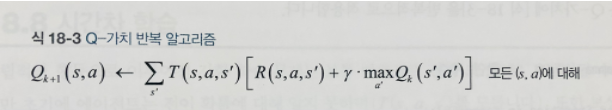

- 최적의 상태-행동 가치 추정
  - Q-가치(Q-Value): 최적의 상태-행동 가치(state-actionvalue)를 추정할 수 있는 알고리즘 ♣
  - Q(s, a): 에이전트가 상태 s에 도달해서 행동 a를 선택한 후 이 행동의 결과를 얻기 전 평균적으로 기대할 수 있는 할인된 미래 보상의 합 ♣
  - Q-가치의 추정을 모두 0으로 초기화 후 Q-가치 반복 알고리즘을 사용해 업데이트 ♣
  - 최적의 Q-가치를 구하면 최적의 정책인 π(s)를 정의하는 것이 가능 ♣
  - 에이전트가 상태 s에 도달했을 때 가장 높은 Q-값을 가진 행동을 선택하면 됨: π*(s)=argmaxQ*(s, a) ♣